## Importing Packages/Functions

In [17]:
import torch
import matplotlib.pyplot as plt
import utils
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.io import read_image
import engine
from importlib import reload
from torch.utils.tensorboard import SummaryWriter
from joblib import load, dump
import numpy as np
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import pandas as pd


labelling_dict = {'Chinchilla': 1,
                  'Hamster': 2,
                  'Rabbit': 3,
                 }

## Load training loss/metrics

In [297]:
loss_dict = load('training_output')

In [298]:
val_losses = loss_dict['Validation']
train_losses = loss_dict['Training']

In [299]:
toe_keys_0 = ['loss',
              'loss_classifier', 
              'loss_box_reg']

toe_keys_1 = ['loss_objectness', 
              'loss_rpn_box_reg']

## Evaluating training loss processes

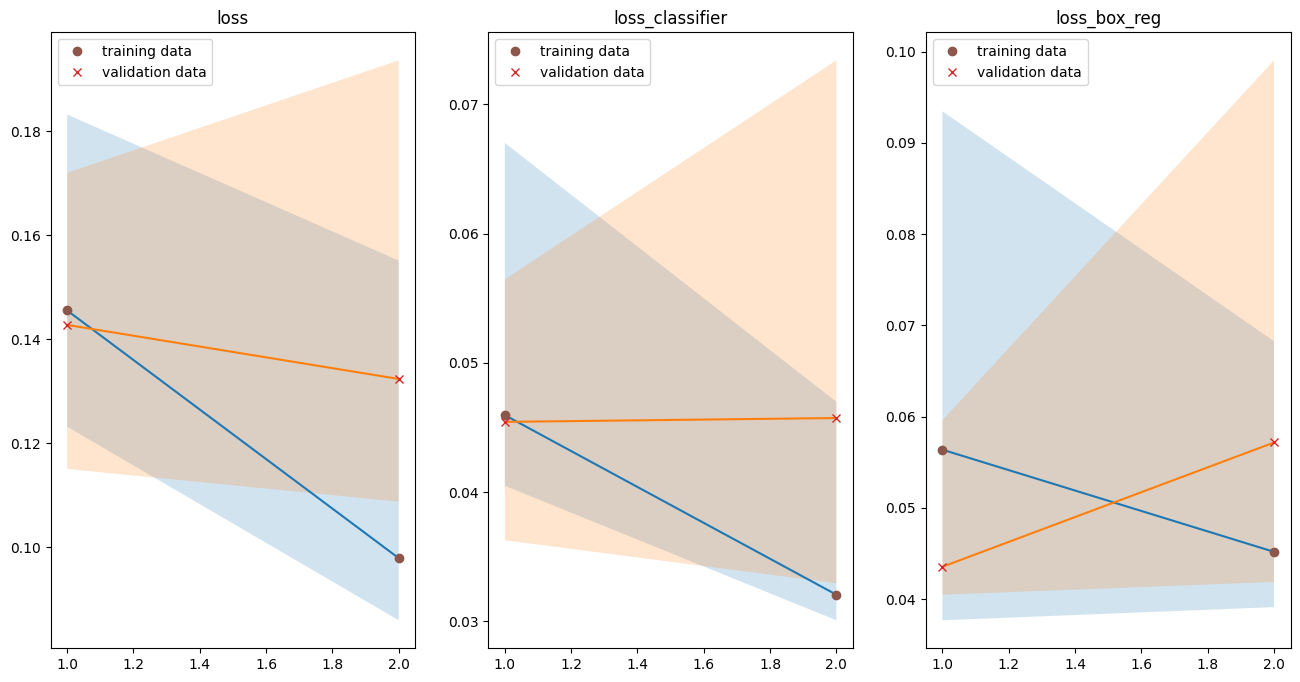

In [300]:
fig, axs = plt.subplots(1,len(toe_keys_0), figsize=(16, 8))
x = np.linspace(1, 
                len(train_losses[f'{toe_keys_1[0]}_Median']), 
                len(train_losses[f'{toe_keys_1[0]}_Median']))

for n0, tk in enumerate(toe_keys_0):
    
    train_y_med = train_losses[f'{tk}_Median']
    train_y_q1 = train_losses[f'{tk}_First_Quartile']
    train_y_q3 = train_losses[f'{tk}_Third_Quartile']


    val_y_med = val_losses[f'{tk}_Median']
    val_y_q1 = val_losses[f'{tk}_First_Quartile']
    val_y_q3 = val_losses[f'{tk}_Third_Quartile']
    # fit a linear curve and estimate its y-values and their error.

    axs[n0].set_title(f"{tk}")
    axs[n0].plot(x, train_y_med, '-')
    axs[n0].plot(x, val_y_med, '-')
    axs[n0].fill_between(x, train_y_q1, train_y_q3, alpha=0.2)
    axs[n0].fill_between(x, val_y_q1, val_y_q3, alpha=0.2)
    axs[n0].plot(x, train_y_med, 'o', color='tab:brown', label="training data")
    axs[n0].plot(x, val_y_med, 'x', color='tab:red', label="validation data")
    axs[n0].legend()
    
plt.show()

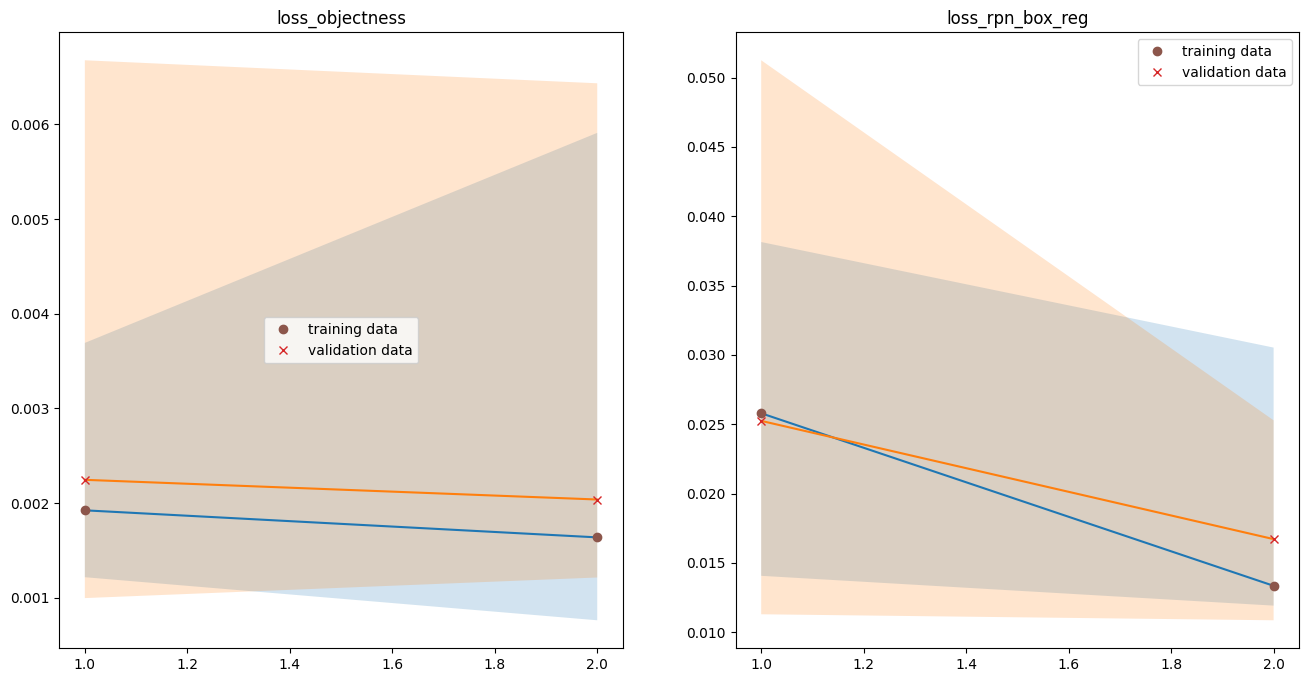

In [301]:
fig, axs = plt.subplots(1,len(toe_keys_1), figsize=(16, 8))
x = np.linspace(1, 
                len(train_losses[f'{toe_keys_1[0]}_Median']), 
                len(train_losses[f'{toe_keys_1[0]}_Median']))

for n0, tk in enumerate(toe_keys_1):
    
    train_y_med = train_losses[f'{tk}_Median']
    train_y_q1 = train_losses[f'{tk}_First_Quartile']
    train_y_q3 = train_losses[f'{tk}_Third_Quartile']


    val_y_med = val_losses[f'{tk}_Median']
    val_y_q1 = val_losses[f'{tk}_First_Quartile']
    val_y_q3 = val_losses[f'{tk}_Third_Quartile']
    # fit a linear curve and estimate its y-values and their error.

    axs[n0].set_title(f"{tk}")
    axs[n0].plot(x, train_y_med, '-')
    axs[n0].plot(x, val_y_med, '-')
    axs[n0].fill_between(x, train_y_q1, train_y_q3, alpha=0.2)
    axs[n0].fill_between(x, val_y_q1, val_y_q3, alpha=0.2)
    axs[n0].plot(x, train_y_med, 'o', color='tab:brown', label="training data")
    axs[n0].plot(x, val_y_med, 'x', color='tab:red', label="validation data")
    axs[n0].legend()
    
plt.show()

## Visualise performance on the test data

In [158]:
model = torch.load('Models/CHR_ResNet')
model.eval()

with open("challenge2\\test_set.txt") as file:
    test_file_md = file.readlines()

In [159]:
def convert_preds_to_df(pred,
                        labelling_dict = labelling_dict):
    
    reversed_dict = {}
    for k,v in labelling_dict.items():
        reversed_dict[v] = k
        
    od = {}
    
    bs = pred['boxes'].cpu().numpy()
    od['xmin'] =  bs[:,0]
    od['ymin'] =  bs[:,1]
    od['xmax'] =  bs[:,2]
    od['ymax'] =  bs[:,3]
    
    labels_nos = pred['labels'].cpu().numpy()
    labels = [] 
    
    for i in range(labels_nos.shape[0]):
        labels.append(reversed_dict[labels_nos[i]])
            
    od['labels'] = labels
    od['scores'] = pred['scores'].cpu().numpy()
    
    return pd.DataFrame(od) 

## Test Set

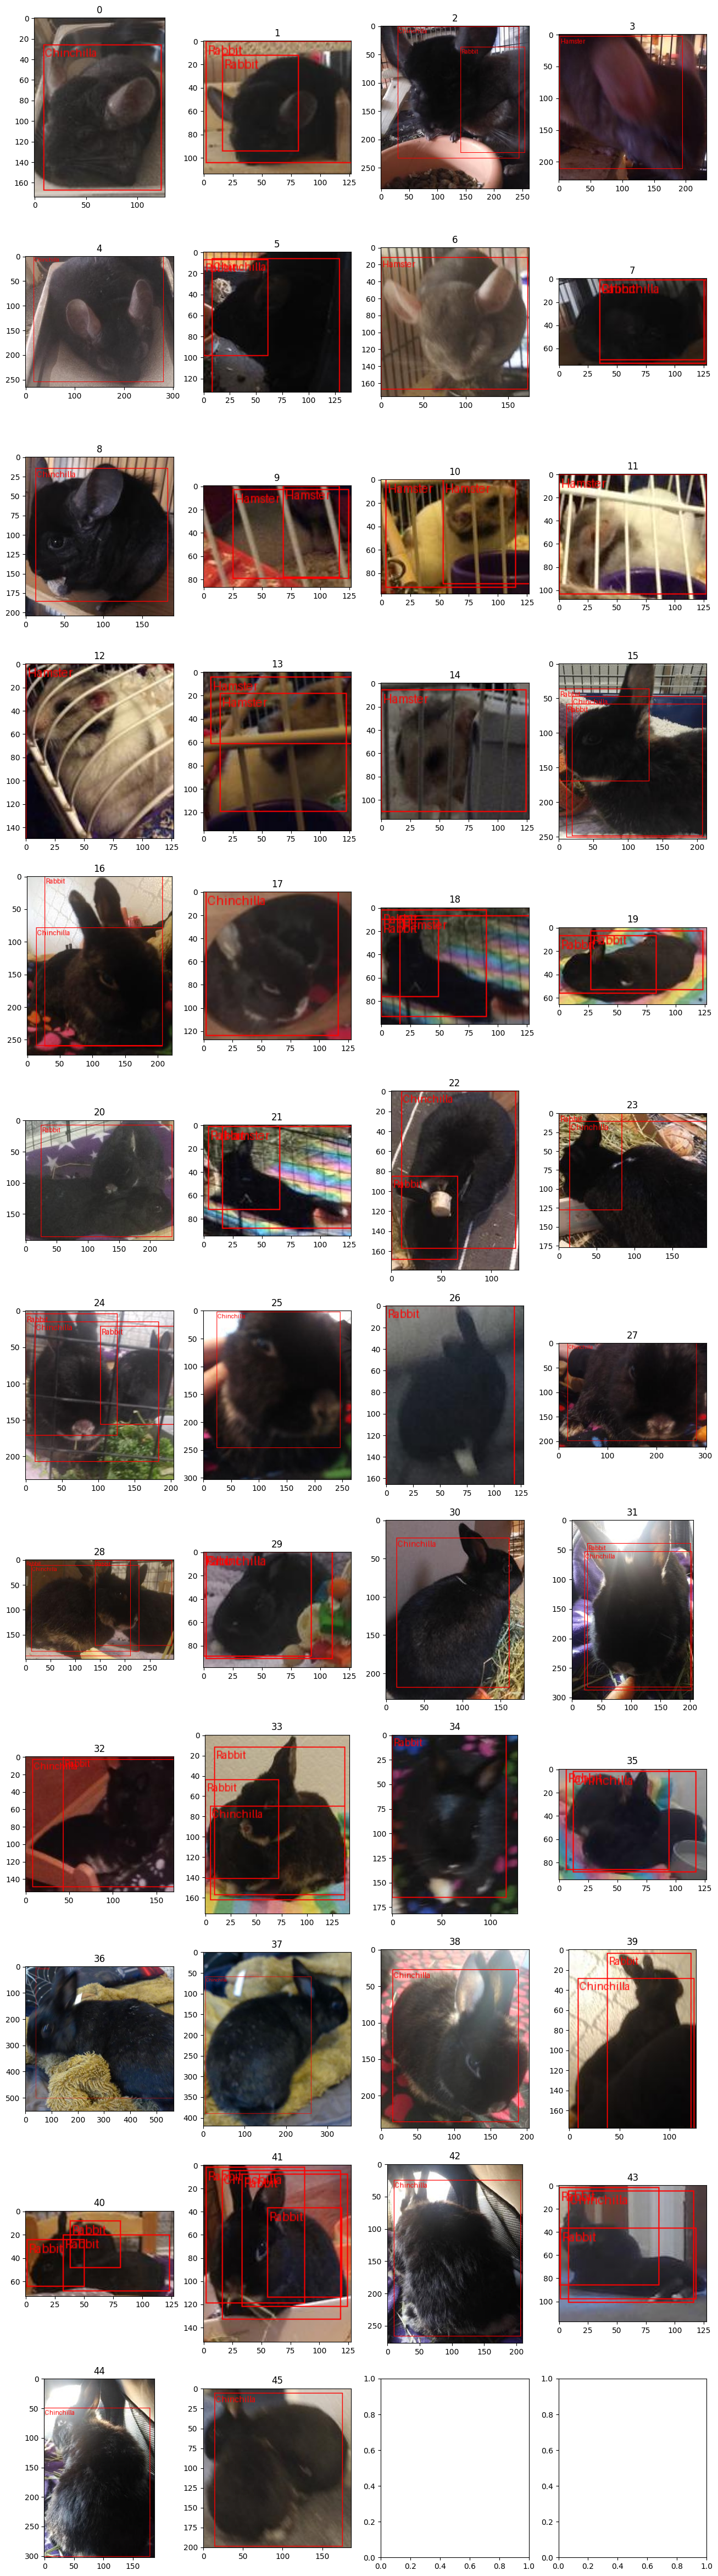

In [302]:

thresh = 0.5

with open("challenge2\\test_set.txt") as file:
    test_file_md = [i[:-1] for i in file.readlines()]

fig, axs = plt.subplots(12, 4, figsize=(16, 60))
num_test_no = {}
preds_dict = {}

for n, fn in enumerate(test_file_md):
    num_test_no[n] = fn
    ##read in the image
    img = (read_image(f"challenge2\\data\\{fn}")*(1/256)).cuda()
    
    with torch.no_grad():
        predictions = model([img, ])
        pred = predictions[0]
    
    pred_df = convert_preds_to_df(pred, labelling_dict)
    pred_df_0_5 = pred_df[pred_df['scores'] >= thresh]
    
    if len(pred_df_0_5) == 0:
        pred_df_0_5 = pred_df.iloc[:2]
        
    preds_dict[n] = {'df': pred_df,
                     'class': fn.split('\\')[0]}
    
    boxes = torch.tensor(pred_df_0_5[['xmin', 'ymin', 'xmax', 'ymax']].values)
    
    output_image = draw_bounding_boxes((img*(256)).to(torch.uint8).cpu(), boxes, pred_df_0_5['labels'], colors="red")
    
    n1 = n//4
    n2 = n%4
    
    axs[n1, n2].imshow(output_image.permute(1, 2, 0))
    
    axs[n1, n2].set_title(f"{n}")

## Training Set

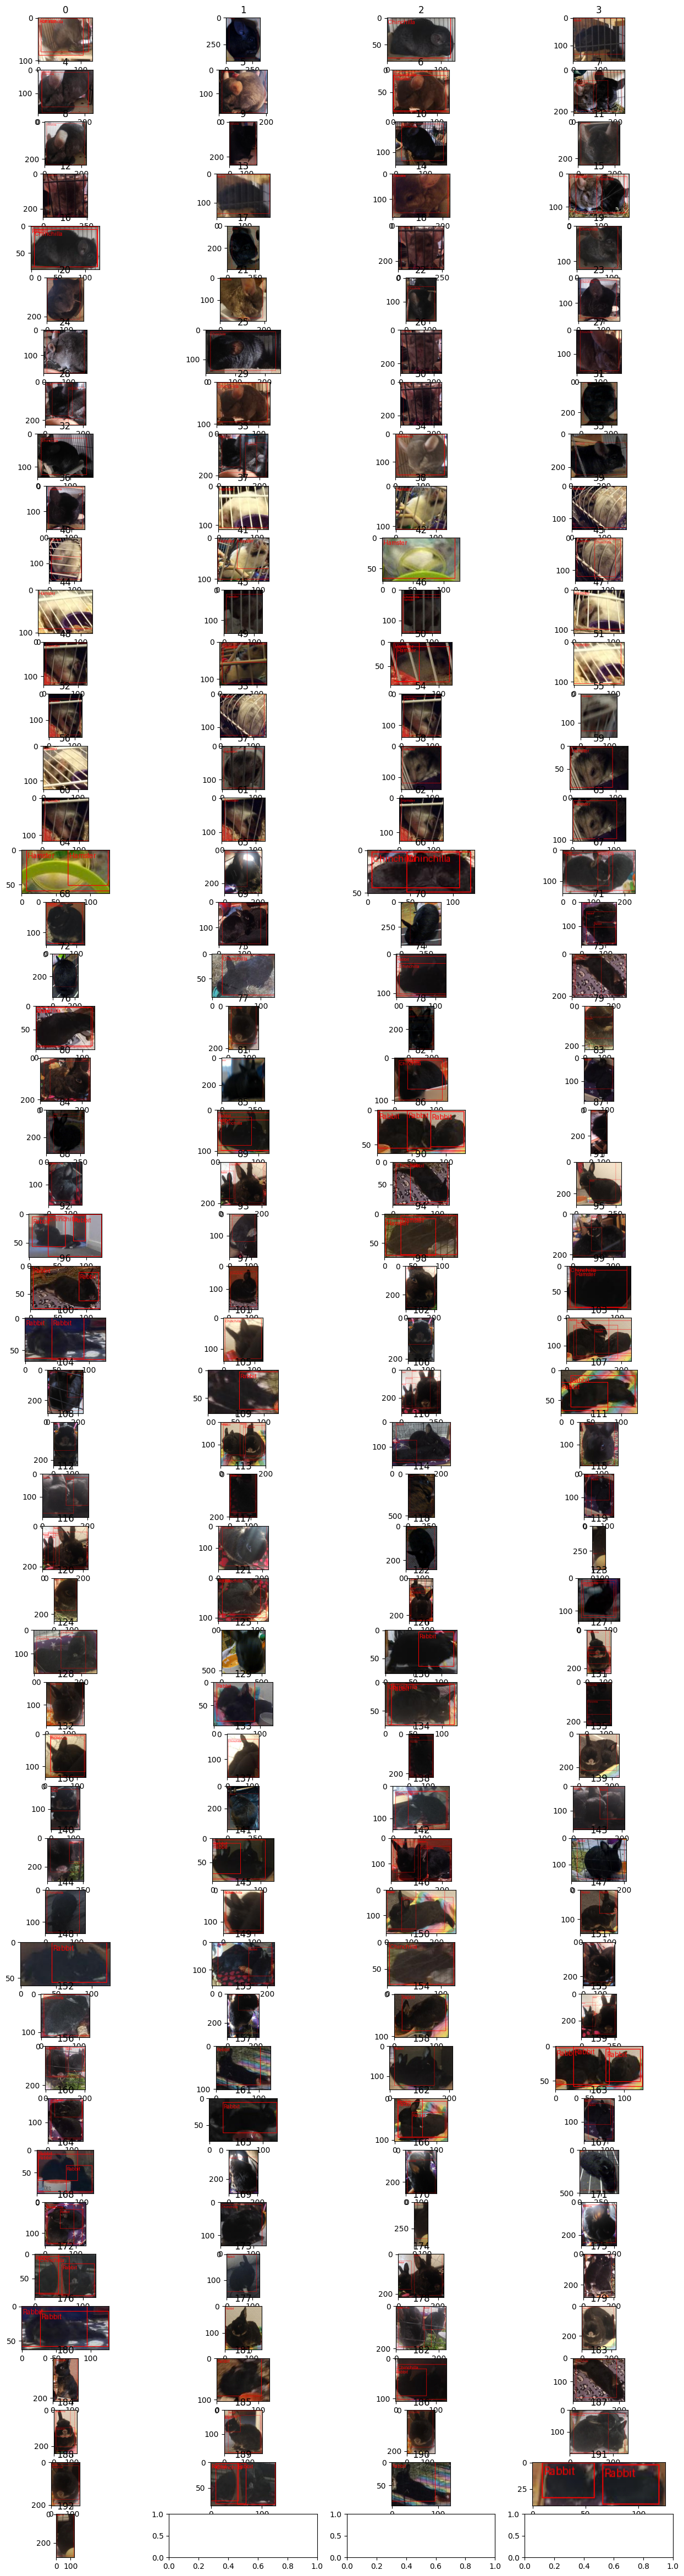

In [317]:
thresh = 0.5

with open("challenge2\\train_set.txt") as file:
    train_file_md = [i[:-1] for i in file.readlines()]

fig, axs = plt.subplots(49, 4, figsize=(16, 60))
num_test_no = {}
preds_dict = {}

for n, fn in enumerate(train_file_md):
    num_test_no[n] = fn
    ##read in the image
    img = (read_image(f"challenge2\\data\\{fn}")*(1/256)).cuda()
    
    with torch.no_grad():
        predictions = model([img, ])
        pred = predictions[0]
    
    pred_df = convert_preds_to_df(pred, labelling_dict)
    pred_df_0_5 = pred_df[pred_df['scores'] >= thresh]
    
    if len(pred_df_0_5) == 0:
        pred_df_0_5 = pred_df.iloc[:2]
        
    preds_dict[n] = {'df': pred_df,
                     'class': fn.split('\\')[0]}
    
    boxes = torch.tensor(pred_df_0_5[['xmin', 'ymin', 'xmax', 'ymax']].values)
    
    output_image = draw_bounding_boxes((img*(256)).to(torch.uint8).cpu(), boxes, pred_df_0_5['labels'], colors="red")
    
    n1 = n//4
    n2 = n%4
    
    axs[n1, n2].imshow(output_image.permute(1, 2, 0))
    
    axs[n1, n2].set_title(f"{n}")

## Contructing A Dataloader For The COCOEval API  

In [303]:
class CHR_Dataset(torch.utils.data.Dataset):
    def __init__(self, 
                 image_list_txt, 
                 annotations_file,
                 labelling_dict,
                 ):

        self.labelling_dict = labelling_dict
        self.annotations_file = pd.read_csv(annotations_file)
        
        with open(f"challenge2\\{image_list_txt}") as file:
            self.file_md = file.readlines()
 
        self.imgs = [f'challenge2\\data\\{i[:-1]}'for i in self.file_md]
    

    def __getitem__(self, idx):
        
        target= {}
        target['image_id'] = idx
        
        lp = self.file_md[idx].split('.')[0]    
        img_path = f'challenge2\\data\\{lp}.jpg'
        img = read_image(img_path).to(torch.float32).cuda()*(1/256)
        
        lp = lp.split('\\')[1]
        if '~' in lp:
            lp = lp.split('~')[0]
        
        annotations = self.annotations_file[self.annotations_file['filename'].str.contains(lp)]
        
        ## check for invalid boxes
        annotations = annotations[((annotations['xmax'] - annotations['xmin']) > 10) &
                                  ((annotations['ymax'] - annotations['ymin']) > 10)]
        
        annotations = annotations.drop(annotations[annotations['xmin'] >= annotations['xmax']].index)
        annotations = annotations.drop(annotations[annotations['ymin'] >= annotations['ymax']].index)
        
        for k, v in labelling_dict.items():
            if k in self.imgs[idx]:
                labels = [v,]*len(annotations)
                target["labels"] = torch.tensor(labels, dtype=torch.int16).cuda()
        
        boxes = annotations[['xmin', 'ymin', 'xmax', 'ymax']].values
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, 
                                                   format="XYXY", 
                                                   canvas_size=F.get_size(img), 
                                                   device = torch.device('cuda')).to(torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["area"] = area
        # no instances are crowd
        iscrowd = torch.zeros((len(annotations),), dtype=torch.int16).cuda()
        target["iscrowd"] = iscrowd
        
        for k, v in labelling_dict.items():
            if k in self.imgs[idx]:
                labels = [v,]*len(annotations)
                target["labels"] = torch.tensor(labels, dtype=torch.int64).cuda()

        return img, target

    def __len__(self):
        return len(self.imgs)

In [313]:
batch_size = 2

test_data = CHR_Dataset('test_set.txt',
                         annotations_file = 'C:\\Users\\richard.nicklin\\Git_Repos\\Coding_Challenge\\test\\_annotations.csv',
                         labelling_dict = labelling_dict,
                         #resizing_transform = transform_resize)
                         )

test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=utils.collate_fn
)

train_data = CHR_Dataset('train_set.txt',
                         annotations_file = 'C:\\Users\\richard.nicklin\\Git_Repos\\Coding_Challenge\\test\\_annotations.csv',
                         labelling_dict = labelling_dict,
                         #resizing_transform = transform_resize)
                         )

train_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=utils.collate_fn
)

## COCO Evaluation on the Test Set

In [311]:
engine.evaluate(model, test_data_loader, device=torch.device('cuda'))

creating index...
index created!
Test:  [ 0/23]  eta: 0:00:10  model_time: 0.4389 (0.4389)  evaluator_time: 0.0020 (0.0020)  time: 0.4478  data: 0.0069  max mem: 1558
Test:  [22/23]  eta: 0:00:00  model_time: 0.2054 (0.4179)  evaluator_time: 0.0020 (0.0019)  time: 0.4103  data: 0.0074  max mem: 1558
Test: Total time: 0:00:09 (0.4273 s / it)
Averaged stats: model_time: 0.2054 (0.4179)  evaluator_time: 0.0020 (0.0019)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU

## COCO Evaluation on the Test Set

In [314]:
engine.evaluate(model, train_data_loader, device=torch.device('cuda'))

creating index...
index created!
Test:  [ 0/23]  eta: 0:01:44  model_time: 4.4082 (4.4082)  evaluator_time: 0.0020 (0.0020)  time: 4.5339  data: 0.1237  max mem: 1558
Test:  [22/23]  eta: 0:00:01  model_time: 1.0282 (1.3396)  evaluator_time: 0.0020 (0.0019)  time: 1.2922  data: 0.1137  max mem: 1558
Test: Total time: 0:00:33 (1.4556 s / it)
Averaged stats: model_time: 1.0282 (1.3396)  evaluator_time: 0.0020 (0.0019)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.402
 Average Recall     (AR) @[ IoU

## PR Curves (Assuming Highest scoring Box as the Classification of the Image, 
## PR Curves constructed as binary curves for each class)

In [304]:
def PR_curve_builder(species,
                     df_dict,
                     thresholds = None):
    if thresholds is None:
        thresholds = np.array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])
    
    precisions = np.zeros(thresholds.shape)
    recalls = np.zeros(thresholds.shape)
    
    for n in range(thresholds.shape[0]):
        i0 = thresholds[n]
        
        tp = 0
        fp = 0
        fn = 0
        for k, v in df_dict.items():
            df = v['df'].copy().sort_values(by=['scores']).reset_index()
            df = df.iloc[-1]
            # true positive criterion
            tpc = all([(df['labels'] == v['class']),
                   (df['scores'] >= i0),
                   (species == v['class'])])
            
            # false positive criterion
            fpc  = all([(df['labels'] == species),
                        (df['scores'] >= i0),
                        (species != v['class'])])
            
            # false negative criteria
            fnc0 = all([(df['labels'] != v['class']),
                   (df['scores'] >= i0),
                   (species == v['class'])])
            
            fnc1 = all([(df['scores'] < i0),
                        (species == v['class'])])
            
            if tpc:
                tp +=1
            elif fpc:
                fp +=1
            elif (fnc0 or fnc1):
                fn += 1
            else: 
                pass
        
        try:  
            precision = tp / (tp + fp)
        except ZeroDivisionError:
            precision = 1.0
            
        try:
            recall = tp / (tp + fn)
        except ZeroDivisionError:
            recall = 0.0
            
        precisions[n] = precision
        recalls[n] = recall
        
        
    return pd.DataFrame({'Thresholds' : thresholds,
                         'Precision': precisions,
                         'Recall':  recalls})
    

In [306]:
species_pr = {}
for k in labelling_dict.keys():
    species_pr[k] = PR_curve_builder(k,
                                     preds_dict)


C:\Users\RICHAR~1.NIC\AppData\Local\Temp/ipykernel_38268/3878313363.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[n0].legend()


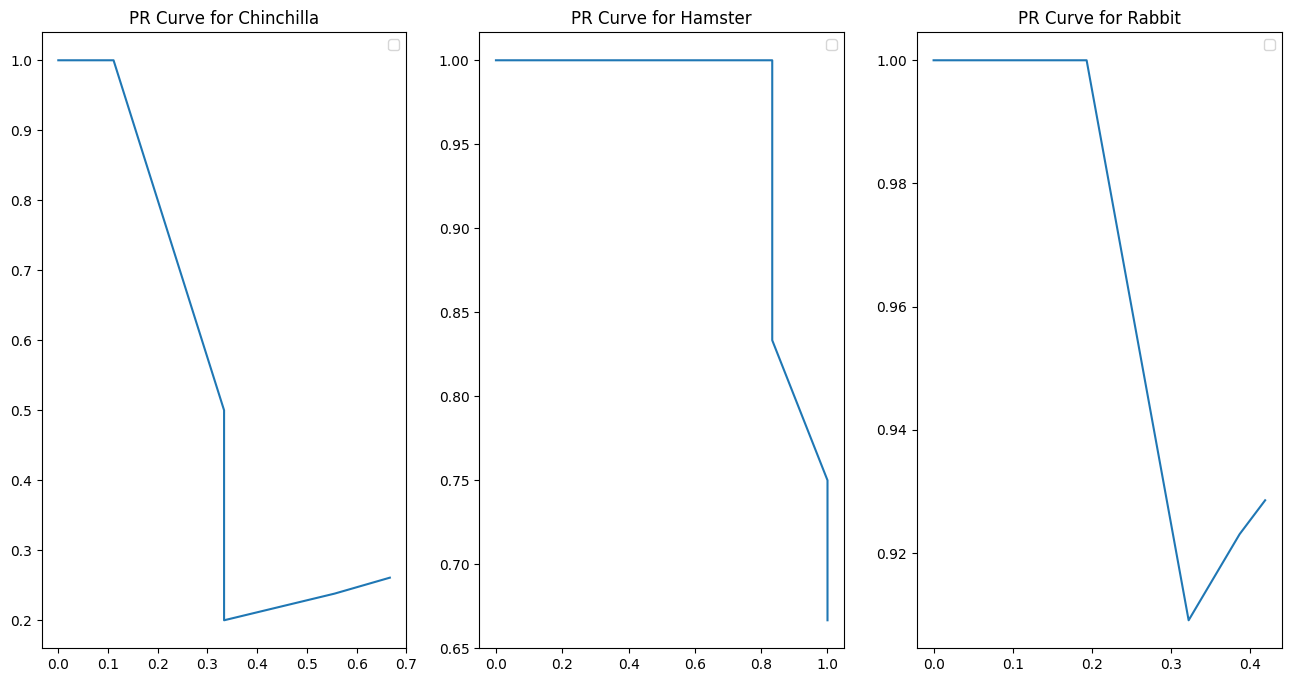

In [309]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
n0 = 0
for k, v in species_pr.items():  
    axs[n0].set_title(f"PR Curve for {k}")
    axs[n0].plot(v['Recall'], v['Precision'], '-')
    axs[n0].legend()
    n0+=1

Note that unusual PR behaviour in the Rabbit/Chinchilla curves is due to heightened confusion between the classes.  

## Conclusions and Observations

1.) The classifier is not as effctive as hoped. There is considerable confusion between the Rabbit and Chinchilla classes.

2.) The classifer's sureness might be improved by expansion of the training set. Scraping the internet for 
Rabbit/Chinchilla images (or a useful dataset from RoboFlow) may yield good results.

3.) Switching to a masking approach (employing a SAM approach) and a more modern model maybe effective (e.g. YOLOv8).

